In [44]:
import os
import random
import torch
import torchvision
import copy
import torchmetrics
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import hsv_to_rgb
from torch import nn
import torch.nn.functional as F
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import torchvision.transforms.functional as TF


In [45]:
class SoftReg(torch.nn.Module):
    '''
    Modelo de regresión softmax
    '''
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(24 * 24 * 3, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.5)
        self.linear4 = nn.Linear(64, 6)

    def forward(self, x):
        # Flatten x with torch.flatten
        x = torch.flatten(x, start_dim=1)
        out = F.relu(self.linear1(x))
        out = self.dropout1(out)
        out = F.relu(self.linear2(out))
        out = self.dropout2(out)
        out = F.relu(self.linear3(out))
        out = self.dropout3(out)
        out = F.softmax(self.linear4(out), dim=-1)
        return out

In [46]:
def train(model, dataloader, loss_fn, optimizer):
    
    '''
    Training loop

    Parameters
    ----------
    model : torch.nn.Module
        Model to train
    dataloader : torch.utils.data.DataLoader
        Dataloader with the training data
    loss_fn : torch.nn.Module
        Loss function
    optimizer : torch.optim.Optimizer
        Optimizer

    Returns
    -------
    None
    '''

    device = next(model.parameters()).device
    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(torch.log(y_pred), y)
        loss.backward()
        optimizer.step()


def test(model, dataloader, loss_fn, metrics_fn):

    '''
    Test loop

    Parameters
    ----------
    model : torch.nn.Module
        Model to test
    dataloader : torch.utils.data.DataLoader
        Dataloader with the testing data
    loss_fn : torch.nn.Module
        Loss function
    metrics_fn : torchmetrics.Metric
        Metric function

    Returns
    -------
    loss_fn : float
        Loss value
    metrics_fn : float
        Metric value
    '''
    
    device = next(model.parameters()).device
    model.eval()
    metrics_fn = metrics_fn.to(device)
    metrics_fn.reset()
    with torch.no_grad():
        loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss += loss_fn(torch.log(y_pred), y).sum()
            metrics_fn.update(y_pred, y)
        
        loss = loss / len(dataloader.dataset)
        metrics = metrics_fn.compute()

    return loss, metrics

In [53]:
# En este ejercicio vamos a ir probando diferentes valores de learning rate, 
# batch size y optimizador para ver cómo afectan al entrenamiento.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SoftReg().to(device)

# Learning rate
lr = 0.001
# Número de epochs de entrenamiento
num_epochs = 50
# Batch size
batch_size = 64
# Optimizador. Otras opciones: Adam, RMSProp, etc. 
# Ver https://pytorch.org/docs/stable/optim.html#algorithms
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Cargamos el dataset (entrenamiento y test)
data_dir = os.path.join('C:/Users/Quique/OneDrive - Universidad Carlos III de Madrid/Master Robotica/Primer Semestre/Procesamiento de imagenes por computador/PIC/dataset-resized2')

transf = torchvision.transforms.Compose([
#    transforms.Resize((28, 28)),  # Redimensiona las imágenes a un tamaño específico
    torchvision.transforms.ToTensor()  # Convierte las imágenes a tensores de PyTorch
])

# Crea una instancia de ImageFolder para cargar el conjunto de datos
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transf)

# Definir el tamaño del conjunto de entrenamiento
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Dividir el conjunto de datos en entrenamiento y prueba
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#dataset_train = torchvision.datasets(root=data_dir, transform=transf)

# Crea un DataLoader para facilitar el acceso a los datos durante el entrenamiento
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False, num_workers=2)

labels = dataset.classes
num_outputs = len(labels)
print(f"Número de clases: {num_outputs}")

# Creamos el modelo, la funcione de pérdida y la métrica de precisión
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.NLLLoss(reduction='sum')
metrics_fn = torchmetrics.classification.MulticlassAccuracy(
    num_classes=num_outputs, average='micro').to(device)

best_acc = 0
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(num_epochs):
    # Entrenamiento
    train(model, train_dataloader, loss_fn, optimizer)

    # Evaluación
    train_loss, train_acc = test(model, train_dataloader, loss_fn, 
        metrics_fn)
    test_loss, test_acc = test(model, test_dataloader, loss_fn, 
        metrics_fn)
    if best_acc <= test_acc:
        best_acc = test_acc
        best_model = copy.deepcopy(model)

    # Almacenamos los valores de pérdida y precisión en cada epoch
    train_loss_history.append(train_loss.cpu())
    train_acc_history.append(train_acc.cpu())
    test_loss_history.append(test_loss.cpu())
    test_acc_history.append(test_acc.cpu())

    print(f'Epoch {epoch}, Precisión (train): {train_acc:.4f}, Loss (train): {train_loss:.4f}')
    print(f'Epoch {epoch}, Precisión (test):  {test_acc:.4f}, Loss (test):  {test_loss:.4f}')

# Guardar modelo
torch.save(model.state_dict(), 'modelo.pth')

# Cargar modelo
#model = SoftReg()
#model.load_state_dict(torch.load('modelo.pth'))


Número de clases: 6
Epoch 0, Precisión (train): 0.1984, Loss (train): 1.7421
Epoch 0, Precisión (test):  0.1984, Loss (test):  1.7421
Epoch 1, Precisión (train): 0.2276, Loss (train): 1.7340
Epoch 1, Precisión (test):  0.2276, Loss (test):  1.7340
Epoch 2, Precisión (train): 0.2390, Loss (train): 1.7391
Epoch 2, Precisión (test):  0.2390, Loss (test):  1.7391
Epoch 3, Precisión (train): 0.2385, Loss (train): 1.7338
Epoch 3, Precisión (test):  0.2385, Loss (test):  1.7338
Epoch 4, Precisión (train): 0.2385, Loss (train): 1.7110
Epoch 4, Precisión (test):  0.2385, Loss (test):  1.7110


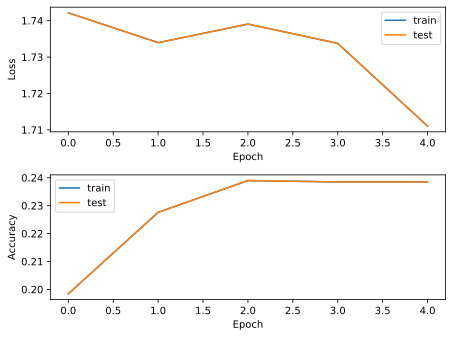

In [54]:
# Gráfica de la evolución de la pérdida y la precisión
plt.subplot(2, 1, 1)
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_acc_history, label='train')
plt.plot(test_acc_history, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

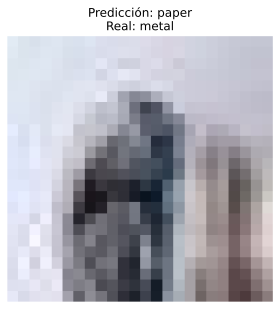

In [56]:
# Visualización de resultados
x, y = next(iter(test_dataloader))
y_pred = model(x.to(device))

# Probamos con una imagen aleatoria del dataset de test
i = random.randint(0, len(x)-1)
# Convierte la imagen a un arreglo NumPy y ajusta las dimensiones si es necesario
image = x[i].cpu().numpy().transpose(1, 2, 0) if x[i].shape[0] == 3 else x[i].cpu().numpy().squeeze()

# Muestra la imagen
plt.imshow(image)
plt.axis('off')

# Obtiene la clase predicha y la clase real
predicted_class = labels[y_pred.argmax(dim=1)[i]]
true_class = labels[y[i]]

# Muestra la predicción y la clase real
plt.title(f'Predicción: {predicted_class}\nReal: {true_class}')
plt.show()